In [2]:
import pandas
df = pandas.read_csv('online_retail.csv')

In [3]:
df.head

<bound method NDFrame.head of         Invoice StockCode                          Description  Quantity  \
0        489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1        489434    79323P                   PINK CHERRY LIGHTS        12   
2        489434    79323W                  WHITE CHERRY LIGHTS        12   
3        489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4        489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   
...         ...       ...                                  ...       ...   
1067366  581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
1067367  581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
1067368  581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
1067369  581587     22138        BAKING SET 9 PIECE RETROSPOT          3   
1067370  581587      POST                              POSTAGE         1   

                 InvoiceDate  Price  Customer ID         

In [4]:
df.isna().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

In [5]:
df.duplicated().sum()

np.int64(34335)

In [6]:
df = df.dropna(subset=['Customer ID'])
df = df.drop_duplicates()
# In this dataset, Invoices starting with 'C' are cancellations.
# We should remove them or handle them so 'Quantity' doesn't go negative.
df = df[~df['Invoice'].str.contains('C', na=False)]
# Filter out non-positive prices or quantities
# Sometimes there are 'Adjustments' or 'Bad Debt' entries with Price 0.
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

print(f"Remaining rows after cleaning: {df.shape[0]}")
print(f"Unique Customers: {df['Customer ID'].nunique()}")

Remaining rows after cleaning: 779425
Unique Customers: 5878


In [7]:
df['Total_Price'] = df['Quantity'] * df['Price']

In [8]:
import numpy as np
import datetime as dt
import pandas as pd

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']) 

# Define the reference date (snapshot date) (because the dataset is from 2009-11, so we make 
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

#  Calculate RFM metrics (note : remember this is important for customer segmentation and its datasets, do check for special metrics in different datasets)
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days, # Recency
    'Invoice': 'nunique',                                   # Frequency
    'Total_Price': 'sum'                                    # Monetary
})
rfm_log = np.log1p(rfm)

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

pca = PCA(n_components=3) 
pca_results = pca.fit_transform(rfm_scaled)

#  DataFrame for the results, because here we did not use train_test_split(because of  Unsupervised Learning), so the results are in array(randomly placed so we did not know the relation between them)
df_pca = pd.DataFrame(
    data = pca_results, 
    columns = ['PC1', 'PC2', 'PC3'],
    index = rfm.index
)


print(f"Total Variance Captured by PC1 & PC2: {np.sum(pca.explained_variance_ratio_[:2])*100:.2f}%")

Total Variance Captured by PC1 & PC2: 95.10%


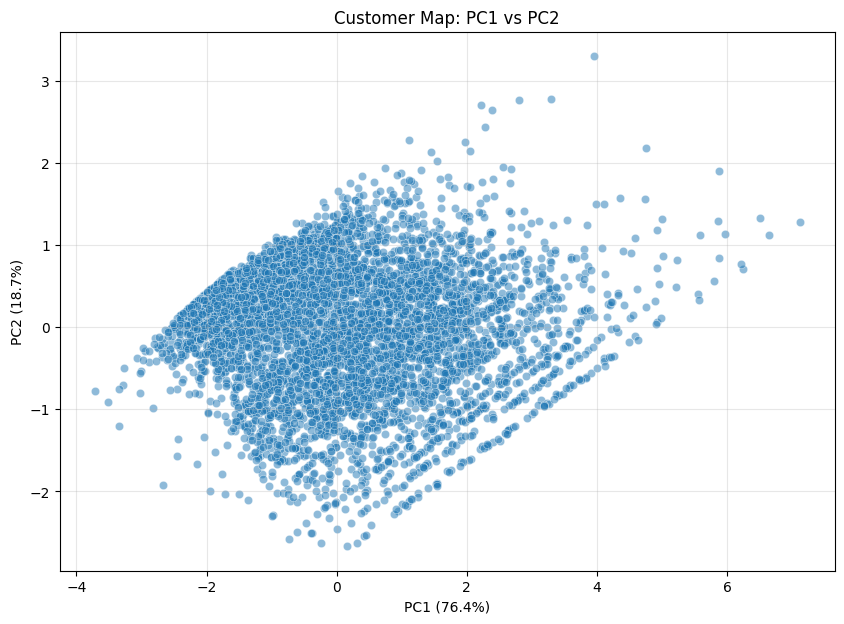

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.scatterplot(x=df_pca['PC1'], y=df_pca['PC2'], alpha=0.5)

plt.title('Customer Map: PC1 vs PC2')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.grid(True, alpha=0.3)
plt.show()

In [11]:
# Check which original features drive which PC
loadings = pd.DataFrame(pca.components_.T, 
                        columns=['PC1', 'PC2', 'PC3'], 
                        index=['Recency', 'Frequency', 'Monetary'])
print(loadings)

                PC1       PC2       PC3
Recency   -0.504633  0.859884  0.077106
Frequency  0.617129  0.296824  0.728730
Monetary   0.603736  0.415325 -0.680447


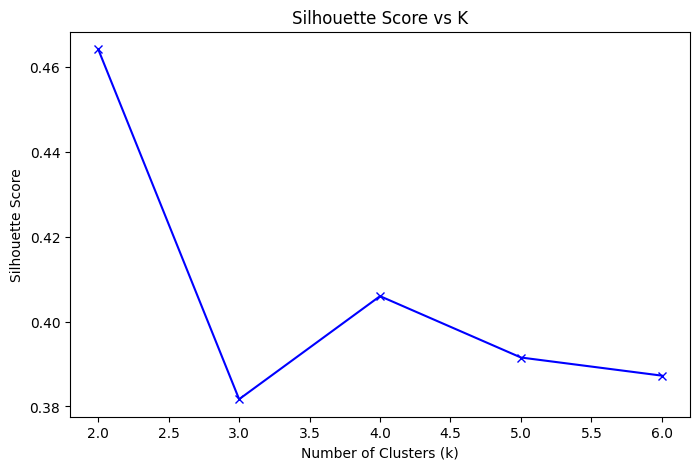

In [59]:
from sklearn.metrics import silhouette_score


k_range = range(2, 7)
scores = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(df_pca[['PC1', 'PC2']])
    score = silhouette_score(df_pca[['PC1', 'PC2']], labels)
    scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(k_range, scores, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs K')
plt.show()



In [60]:
from sklearn.cluster import KMeans

n_clusters = 4 
kmeans_final = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)

kmeans_final.fit(df_pca[['PC1', 'PC2']])

labels = kmeans_final.predict(df_pca[['PC1', 'PC2']])
rfm['Cluster'] = labels


In [61]:
#  Rename the columns so the .agg() function can find them
#  map the raw names to the human-readable RFM names
rfm_renamed = rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency',
    'Total_Price': 'Monetary'
})

cluster_profile = rfm_renamed.groupby('Cluster').agg({
    'Recency': 'mean','Frequency':'mean','Monetary': ['mean', 'count']
}).round(1)

# 3. Clean up the column headers
cluster_profile.columns = ['Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Count']

# 4. Sort and display
display(cluster_profile.sort_values(by='Avg_Monetary', ascending=False))

,Avg_Recency,Avg_Frequency,Avg_Monetary,Count
Cluster,,,,
2,26.9,19.3,10782.8,1190
3,224.4,5.2,1965.4,1459
0,28.1,3.1,829.2,1228
1,394.5,1.4,328.6,2001


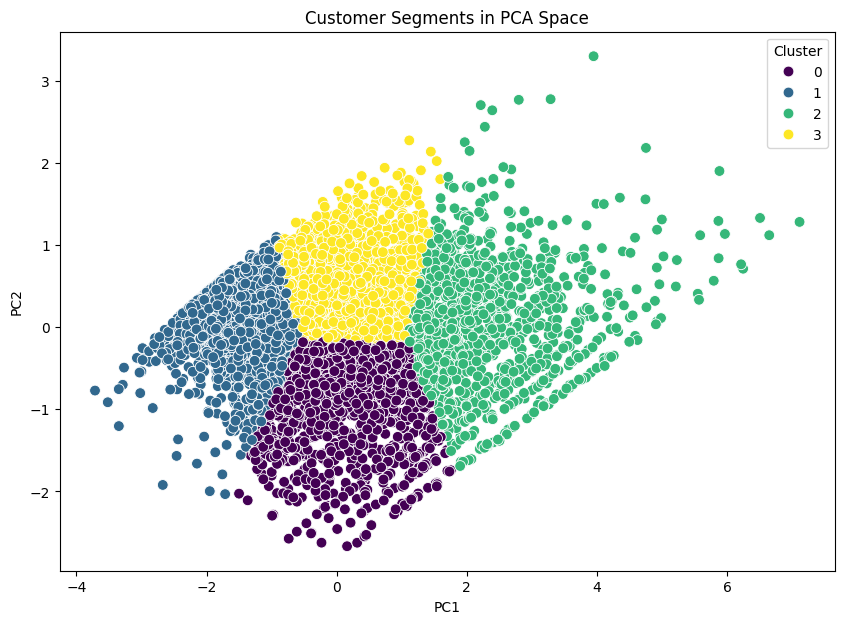

In [62]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x=df_pca['PC1'], y=df_pca['PC2'], hue=rfm['Cluster'], palette='viridis', s=60)
plt.title('Customer Segments in PCA Space')
plt.show()

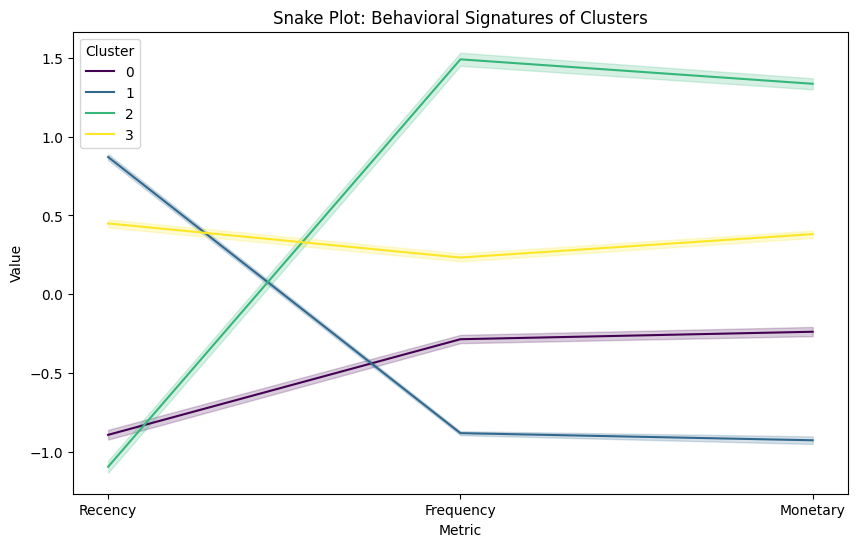

In [63]:
# (use the scaled data but add the cluster labels)
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'], index=rfm.index)
rfm_scaled_df['Cluster'] = rfm['Cluster']

# Melt the data for visualization
rfm_melted = pd.melt(rfm_scaled_df.reset_index(), 
                     id_vars=['Customer ID', 'Cluster'],
                     value_vars=['Recency', 'Frequency', 'Monetary'],
                     var_name='Metric', value_name='Value')

plt.figure(figsize=(10, 6))
sns.lineplot(x='Metric', y='Value', hue='Cluster', data=rfm_melted, palette='viridis')
plt.title('Snake Plot: Behavioral Signatures of Clusters')
plt.show()

In [64]:
y = rfm['Cluster']

# here, we are using RFM just for human understanding
X = rfm_renamed[['Recency', 'Frequency', 'Monetary']]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 4702
Testing set size: 1176


In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       246
           1       1.00      1.00      1.00       400
           2       0.96      0.97      0.97       238
           3       0.97      0.96      0.97       292

    accuracy                           0.98      1176
   macro avg       0.98      0.98      0.98      1176
weighted avg       0.98      0.98      0.98      1176



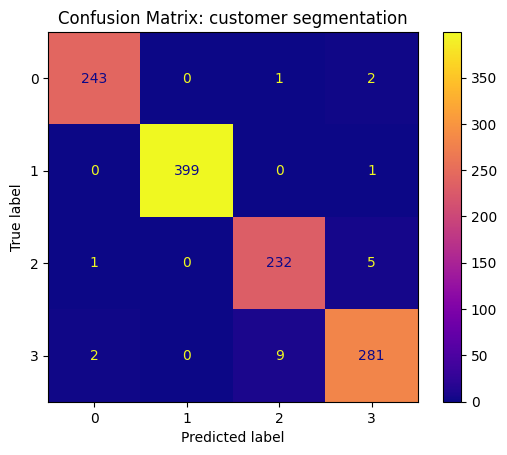

In [66]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1','2','3'])
disp.plot(cmap=plt.cm.plasma)
plt.title('Confusion Matrix: customer segmentation')
plt.show()

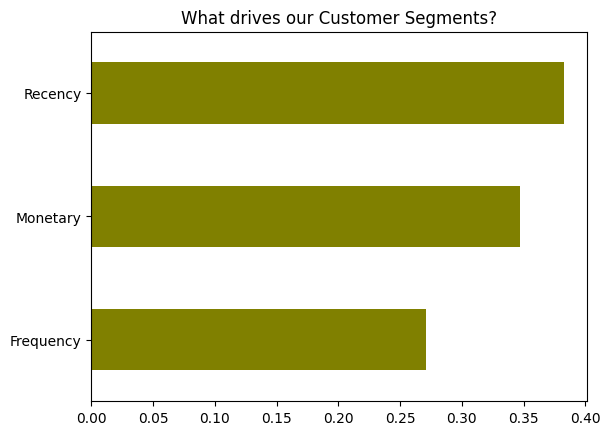

In [67]:
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', color='olive')
plt.title('What drives our Customer Segments?')
plt.show()

In [68]:
#predicting a new person
def predict_segment(recency, frequency, monetary):
    data = pd.DataFrame([[recency, frequency, monetary]], columns=['Recency', 'Frequency', 'Monetary'])
    segment = rf_model.predict(data)[0]
    return f"This customer belongs to Cluster {segment}"

print(predict_segment(recency=5, frequency=50, monetary=10000))

This customer belongs to Cluster 2
